## Nagy Enikő - IKZ9P3 - Intellingens fejlesztő környezetek - féléves beadandó - hangfájlok klasszifikációja konvolúciós neurális hálózatok segítségével Python nyelv használatával

# Függőségek

In [178]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa #audio fájlok beolvasása
import librosa.display
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn #grafikus megjelenítés
seaborn.set(style='ticks')
from IPython.display import Audio # az audio filok megjelenítéséhez szükséges
import scipy
from pathlib import Path


# Munka könyvtár előkészítése

In [179]:
# A könyvtárban található fájlok
!ls

hangoskonyv  README.md	requirements.txt  version5.ipynb  versionFinal.ipynb


In [180]:
#Újragyártom az mp3 fájlokat a kód során, így a kód elején törlöm az előzőeket

!rm -rf ./hangoskonyv/benedek
!rm -rf ./hangoskonyv/noimese


!mkdir hangoskonyv/benedek
!mkdir hangoskonyv/noimese

!cp hangoskonyv/benedek_elek.mp3 hangoskonyv/benedek
!cp hangoskonyv/noi_mesemondo.mp3 hangoskonyv/noimese


In [181]:
#Wav fájlok törlése

file = Path("/hangoskonyv/benedek/benedek_elek.wav")
if file.is_file():
    !rm ./hangoskonyv/benedek/benedek_elek.wav

file = Path("/hangoskonyv/noimese/noi_mesemondo.wav")
if file.is_file():
    !rm ./hangoskonyv/noimese/noi_mesemondo.wav



# Adatok előfeldolgozása, átalakítása

## A két MP3 fájl átalakítása .wav fájllá

In [182]:
# Két mp3 fájl átalakítása .wav fájllá - sampling rate 22 050

!ffmpeg -i hangoskonyv/benedek/benedek_elek.mp3 -acodec pcm_s16le -ar 22050 hangoskonyv/benedek/benedek_elek.wav

!ffmpeg -i hangoskonyv/noimese/noi_mesemondo.mp3 -acodec pcm_s16le -ar 22050 hangoskonyv/noimese/noi_mesemondo.wav

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

## A két wav fájl feldarabolása 3 másodperces darabokra


In [183]:
#A két wav fájl feldarabolása 3 másodperces darabokra (tanítási minták elkészítése) 

!ffmpeg -i hangoskonyv/benedek/benedek_elek.wav -f segment -segment_time 3 -c copy hangoskonyv/benedek/be%03d.wav

!ffmpeg -i hangoskonyv/noimese/noi_mesemondo.wav -f segment -segment_time 3 -c copy hangoskonyv/noimese/no%03d.wav



ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [184]:
%matplotlib inline

# Adatok beolvasása

In [185]:
# Segéd CSV fájl beolvasása
data = pd.read_csv('hangoskonyv/metadata/Hangoskonyv.csv')

In [186]:
# Méret lekérdezése
data.shape

(200, 8)

In [187]:
# valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data = data

In [188]:
# valid data típusának lekérdezése
type(valid_data)

pandas.core.frame.DataFrame

In [189]:
# valid data oszlopai
valid_data.columns

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'],
      dtype='object')

# Spektrum analízis

## Melspektrogram teszt férfi hangfájlra

In [190]:
# Benedek hangminta
y, sr = librosa.load('hangoskonyv/benedek/be051.wav', duration=2.97)

# Short time fourier transform
d = np.abs(librosa.stft(y))

In [191]:
#Melspekrogram elkészítése csak erre az egy hárommásodperces be051-es hangszeletre
ps = librosa.feature.melspectrogram(y=y, sr=sr, power=1.0)
ps.shape

(128, 128)

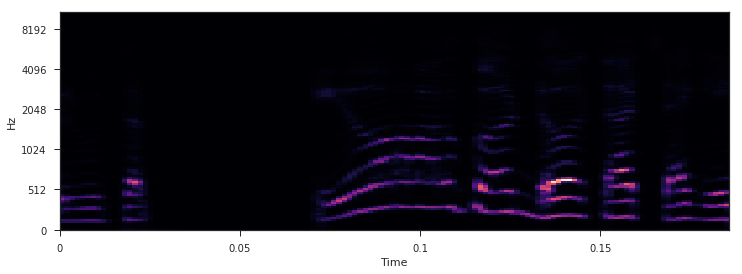

In [192]:
#Melspektrogram megjelenítése
plt.figure(figsize=(12,4))

librosa.display.specshow(ps, sr=sr, hop_length=32, y_axis='mel', x_axis='time')

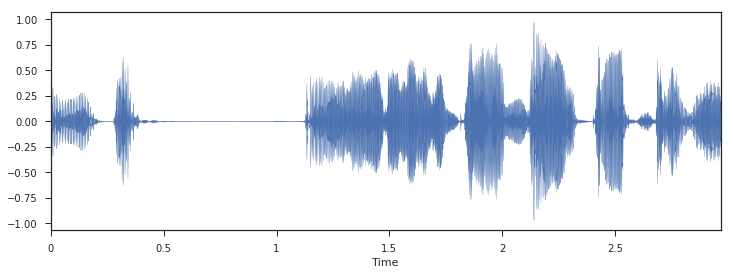

In [193]:
# Waveplot kirajzolása - hogy összehasonlítható legyen az elkészült melspektrogrammal
plt.figure(figsize=(12,4))
librosa.display.waveplot(y, sr)

In [194]:
#Hangszelet lejátszása
Audio(data = y, rate = sr)

In [195]:
#Hangszelet méretei
print(y.shape, sr)

(65489,) 22050


## Melspektrogram teszt női hangfájlra

In [196]:
# Női hangmintából teszt melspektrogram készítése
y, sr = librosa.load('hangoskonyv/noimese/no003.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr, power=1.0)
ps.shape

(128, 128)

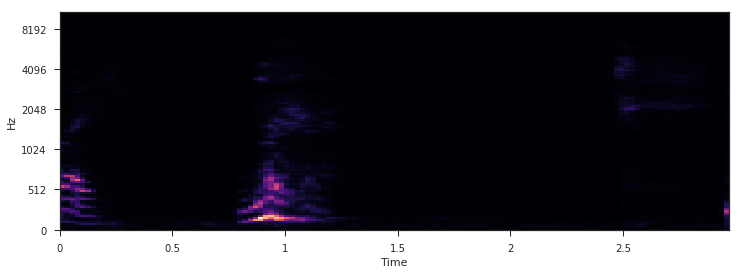

In [197]:
#Az elkészült melspektrogram megjelenítése
plt.figure(figsize=(12,4))
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

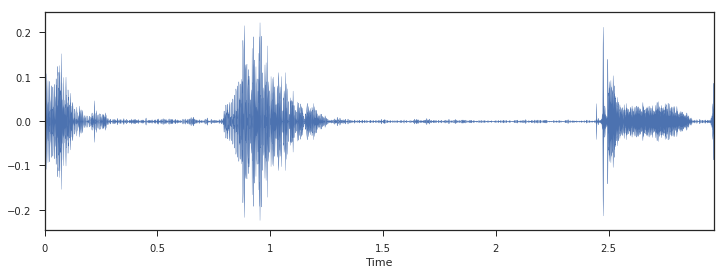

In [198]:
# Waveplot kirajzolása - hogy összehasonlítható legyen az elkészült melspektrogrammal
plt.figure(figsize=(12,4))
librosa.display.waveplot(y, sr)

In [199]:
#Hangszelet lejátszása
Audio(data = y, rate = sr)

## Adatok ellenőrzése átalakítás előtt

In [200]:
#input adatok ellenőrzése
valid_data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,be001.wav,100032,0,8,1,1,0,benedek
1,be002.wav,100263,0,8,1,1,0,benedek
2,be003.wav,100263,0,8,1,1,0,benedek
3,be004.wav,100263,0,8,1,1,0,benedek
4,be005.wav,100263,0,8,1,1,0,benedek


In [201]:
#input adatok méreteinek ellenőrzése
valid_data.size

1600

In [202]:
#új oszlop készítése ami a teljes elérési útvonalat tartalmazza
valid_data['path'] = valid_data['class'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [203]:
valid_data['path']

0      benedek/be001.wav
1      benedek/be002.wav
2      benedek/be003.wav
3      benedek/be004.wav
4      benedek/be005.wav
5      benedek/be006.wav
6      benedek/be007.wav
7      benedek/be008.wav
8      benedek/be009.wav
9      benedek/be010.wav
10     benedek/be011.wav
11     benedek/be012.wav
12     benedek/be013.wav
13     benedek/be014.wav
14     benedek/be015.wav
15     benedek/be016.wav
16     benedek/be017.wav
17     benedek/be018.wav
18     benedek/be019.wav
19     benedek/be020.wav
20     benedek/be021.wav
21     benedek/be022.wav
22     benedek/be023.wav
23     benedek/be024.wav
24     benedek/be025.wav
25     benedek/be026.wav
26     benedek/be027.wav
27     benedek/be028.wav
28     benedek/be029.wav
29     benedek/be030.wav
             ...        
170    noimese/no071.wav
171    noimese/no072.wav
172    noimese/no073.wav
173    noimese/no074.wav
174    noimese/no075.wav
175    noimese/no076.wav
176    noimese/no077.wav
177    noimese/no078.wav
178    noimese/no079.wav


In [204]:
#új adatszerkezet ellenőrzése
valid_data.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class,path
195,no096.wav,103076,0,8,1,10,1,noimese,noimese/no096.wav
196,no097.wav,103199,0,8,1,10,1,noimese,noimese/no097.wav
197,no098.wav,103199,0,8,1,10,1,noimese,noimese/no098.wav
198,no099.wav,103199,0,8,1,10,1,noimese,noimese/no099.wav
199,no100.wav,103199,0,8,1,10,1,noimese,noimese/no100.wav


# Wav fájlok átalakítása spektrogramokká 

In [205]:
#Új táblázat készítése ami minden spectrogrammot és címkét tartalmaz 
#Végig megyünk az összes valid dataframe adaton és mindegyikből csinálunk egy (128,128) felbontású spectrogrammot a librosa segítségével
D = [] # Dataset

i = 0

for row in valid_data.itertuples():
    y, sr = librosa.load('hangoskonyv/' + row.path, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue #csak a 128*128 méretűeket használjuk (a végén maradt 1 mp-eseket nem)
    D.append( (ps, row.classID) )

## Adatok ellenőrzése spektrogrammá alakítás után

In [206]:
#új adattömb méretének lekérdezése
print("Number of samples: ", len(D))

Number of samples:  200


In [207]:
#128*128 * 200
print(D[1])

(array([[  3.38262811e-03,   1.41626787e-02,   3.55338339e-02, ...,
          3.72456520e+00,   2.11549826e-01,   1.04516749e+00],
       [  4.59420216e-03,   3.65292496e-03,   1.42711002e-03, ...,
          2.54318095e-01,   3.31276002e-02,   8.81552005e-01],
       [  1.14393106e-02,   1.40381650e-02,   6.25061550e-03, ...,
          1.48979464e-01,   4.93325410e-02,   1.49435214e+00],
       ..., 
       [  6.67012069e-06,   2.02913718e-06,   9.45957571e-07, ...,
          1.12387639e-05,   2.44968274e-06,   5.49525784e-06],
       [  6.30741531e-06,   1.58208246e-06,   6.04914289e-09, ...,
          3.82559170e-07,   5.88022105e-09,   2.15819740e-07],
       [  6.02678898e-06,   1.51441609e-06,   7.52905167e-09, ...,
          7.18615019e-09,   7.19686095e-09,   3.01664295e-07]]), 0)


# Adatok összekeverése

In [208]:
#Mivel az erdeti adataink erősen szekvenciálisak voltak (az első száz "A" a második száz "B" ezért keverjük össze őket
dataset = D
random.shuffle(dataset)


## Adatok ellenőrzése összekeverés után

In [209]:
print(dataset[1])

(array([[  1.27117813e+00,   3.15257244e-01,   4.60692532e-04, ...,
          1.44832987e-03,   5.95469188e-04,   1.64521206e-04],
       [  1.54847496e+00,   3.88919052e-01,   3.67540472e-03, ...,
          2.80372153e-03,   4.62676300e-03,   2.97389877e-03],
       [  1.66003781e+00,   4.22760774e-01,   3.18329952e-02, ...,
          1.09612088e-02,   3.02938750e-02,   3.24487163e-02],
       ..., 
       [  8.39113559e-06,   2.11189345e-06,   1.67044746e-08, ...,
          1.74567183e-08,   1.41289250e-08,   3.84865182e-08],
       [  8.25756855e-06,   2.07216528e-06,   1.79302721e-08, ...,
          1.26793973e-08,   1.09248346e-08,   2.72466642e-08],
       [  7.95266208e-06,   1.99875414e-06,   1.11857798e-08, ...,
          1.03350094e-08,   8.03705332e-09,   1.62989941e-08]]), 1)


In [210]:
type(dataset)

list

In [211]:
dataset[6]

(array([[  2.90651829e-03,   1.17709438e-03,   2.84204142e-03, ...,
           3.50444375e-03,   4.51997642e-03,   5.75191676e-03],
        [  1.29478350e-02,   1.20617198e-02,   1.89025831e-02, ...,
           2.19151573e-02,   3.42066378e-02,   1.81013297e-02],
        [  3.00962558e-03,   1.18473535e-02,   3.11928180e-02, ...,
           2.58878709e-02,   4.80615008e-02,   6.07920051e-02],
        ..., 
        [  7.34454912e-07,   1.90757491e-07,   7.65049495e-09, ...,
           1.01498164e-08,   1.58196512e-08,   7.86847622e-06],
        [  6.08335625e-07,   1.57664444e-07,   1.18905145e-08, ...,
           1.10538114e-08,   9.59950265e-09,   7.70531449e-06],
        [  5.71261703e-07,   1.48381432e-07,   1.03965423e-08, ...,
           1.23154363e-08,   1.37730428e-08,   7.62226429e-06]]), 1)

In [212]:
# Az összekeverés ellenőrzése
for i in range(0,20):
    print(dataset[i][1], end=' ')

0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 

# Az összekevert adatok szétválasztása tanító és teszt mintákra

In [213]:
#Összesen 200 input adat, ebből a tanítási adat 150, 50 pedig a teszt adat lesz, amivel validáljuk a modellünket
train = dataset[:150]
test = dataset[150:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

## Adatok ellenőrzése szétválasztás után


In [214]:
#tanító adatok típusának lekérdezése
type(train)

list

In [215]:
#X_train adatok típusának lekérdezése (ezek már a melspektrogramok adatai)
type(X_train)

tuple

In [216]:
# X_train[1][1]

X_train[1]

array([[  1.27117813e+00,   3.15257244e-01,   4.60692532e-04, ...,
          1.44832987e-03,   5.95469188e-04,   1.64521206e-04],
       [  1.54847496e+00,   3.88919052e-01,   3.67540472e-03, ...,
          2.80372153e-03,   4.62676300e-03,   2.97389877e-03],
       [  1.66003781e+00,   4.22760774e-01,   3.18329952e-02, ...,
          1.09612088e-02,   3.02938750e-02,   3.24487163e-02],
       ..., 
       [  8.39113559e-06,   2.11189345e-06,   1.67044746e-08, ...,
          1.74567183e-08,   1.41289250e-08,   3.84865182e-08],
       [  8.25756855e-06,   2.07216528e-06,   1.79302721e-08, ...,
          1.26793973e-08,   1.09248346e-08,   2.72466642e-08],
       [  7.95266208e-06,   1.99875414e-06,   1.11857798e-08, ...,
          1.03350094e-08,   8.03705332e-09,   1.62989941e-08]])

In [217]:
#Az X_train egy eleme egy 128*128-as ndarray tömb
type(X_train[1])

numpy.ndarray

In [218]:
len(X_train[1])

128

In [219]:
type(y_train)

tuple

In [220]:
y_train[1:10]

(1, 1, 0, 1, 1, 1, 1, 1, 1)

In [221]:
len(y_train)

150

In [222]:
type(y_train[1])

numpy.int64

In [223]:
# Keras ilyen tensorflow formában kéri az adatokat CNN bemenetén
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])


# One-Hot encoding transzformáció

In [224]:
# One-Hot encoding használata - azért, hogy a modell kibővíthető legyen, ne csak férfi/nő minta legyen később
y_train = np.array(keras.utils.to_categorical(y_train, 2))
y_test = np.array(keras.utils.to_categorical(y_test, 2))

## Adatok ellenőrzése one-hot encoding után

In [225]:
y_train[1:10]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

In [226]:
X_train.shape

(150, 128, 128, 1)

In [227]:
y_train.shape

(150, 2)

In [228]:
y_train[1]

array([ 0.,  1.], dtype=float32)

# Keras konvolúciós neurális hálózat modelljének összeállítása

In [229]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape)) 
model.add(MaxPooling2D((4, 2), strides=(4, 2))) 
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid")) 
model.add(MaxPooling2D((4, 2), strides=(4, 2))) 
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid")) 
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(2))
model.add(Activation('sigmoid'))


In [230]:
#Iteráció szám és batch size beállítása
epoch = 30

batch_size = 32


# Elkészített CNN modell alkalmazása és tanítása

In [231]:
model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=['accuracy'])

model_history = model.fit(
    x=X_train, 
    y=y_train,
    epochs=epoch,
    batch_size=batch_size,
    validation_data= (X_test, y_test),
   )

# callbacks=[tbCallBack]

Train on 150 samples, validate on 50 samples
Epoch 1/30
150/150 [==============================] - 2s 16ms/step - loss: 2.9958 - acc: 0.5167 - val_loss: 0.8044 - val_acc: 0.6400
Epoch 2/30
150/150 [==============================] - 2s 14ms/step - loss: 1.9069 - acc: 0.5633 - val_loss: 0.7173 - val_acc: 0.7100
Epoch 3/30
150/150 [==============================] - 2s 13ms/step - loss: 1.4940 - acc: 0.6167 - val_loss: 0.3828 - val_acc: 0.8000
Epoch 4/30
150/150 [==============================] - 2s 13ms/step - loss: 0.8521 - acc: 0.6867 - val_loss: 0.2959 - val_acc: 0.8600
Epoch 5/30
150/150 [==============================] - 2s 13ms/step - loss: 0.6536 - acc: 0.7100 - val_loss: 0.2358 - val_acc: 0.9700
Epoch 6/30
150/150 [==============================] - 2s 12ms/step - loss: 0.3502 - acc: 0.8633 - val_loss: 0.2255 - val_acc: 0.9700
Epoch 7/30
150/150 [==============================] - 2s 14ms/step - loss: 0.3533 - acc: 0.9000 - val_loss: 0.1624 - val_acc: 0.9800
Epoch 8/30
150/150 [====

# Evaluate - kiértékelés

In [232]:
score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

50/50 [==============================] - 0s 4ms/step
Test loss: 0.0713421994424
Test accuracy: 0.98


# Súlyok elmentése

In [233]:
Wsave = model.get_weights()

In [234]:
# súlyok típusának lekérdezése
type(Wsave)

list

In [235]:
#ha újra be szeretném állítani őket akkor
# model.set_weights(Wsave)

# CNN modell paraméterei

In [236]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
activation_16 (Activation)   (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
activation_17 (Activation)   (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 25, 48)         57648     
__________

# Tanulási folyamat kirajzolása

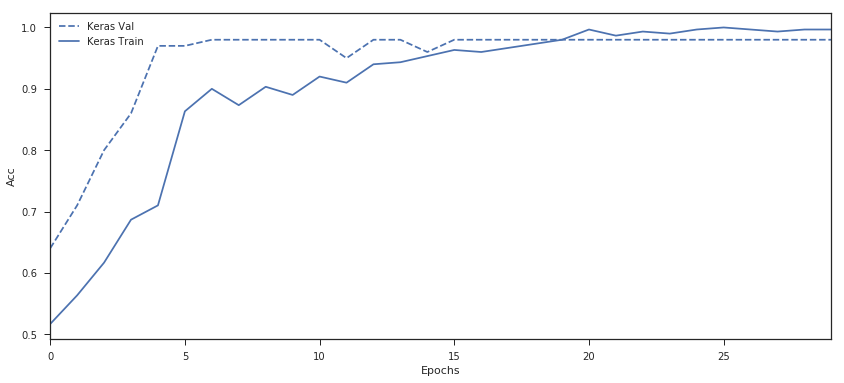

In [237]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(14,6))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    
    plt.xlim([0,max(history.epoch)])


plot_history([('keras', model_history)], key='acc')